In [1]:
import glob
import cv2
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter

from torchsummary import summary

import albumentations as A
from albumentations.pytorch import ToTensorV2

import numpy as np
import xml.etree.ElementTree as ET

from copy import deepcopy

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [3]:
root_dir = './datasets/dogs'
img_dir = '/images/Images/'
annot_dir = '/annotations/Annotation/'

In [4]:
import os

labels_map = {}
for i, item in enumerate(os.listdir(root_dir + img_dir)):
    sub_folder = os.path.join(root_dir + img_dir, item)
    labels_map[sub_folder.split('-', maxsplit=1)[1]] = i

In [5]:
def img_crop(annot_path, img):
    tree = ET.parse(annot_path)
    obj = tree.find('./object')
    bndbox = obj.find('bndbox')

    # 강아지 종류
    species = obj.find('name').text

    # 이미지에서의 강아지 위치
    xmin = int(bndbox.find('xmin').text)
    ymin = int(bndbox.find('ymin').text)
    xmax = int(bndbox.find('xmax').text)
    ymax = int(bndbox.find('ymax').text)

    cropped_img = img[ymin:ymax, xmin:xmax]
    
    label = labels_map.get(species)

    return label, cropped_img

In [6]:
class DogsDataset(Dataset):
    def __init__(self, annot_dir, img_dir, transform=None):
        self.annot_dir = glob.glob(root_dir + annot_dir + '*/*')
        self.img_dir = glob.glob(root_dir + img_dir + '*/*.jpg')
        self.transform = transform
        
    def __len__(self):
        return len(self.img_dir)
        
    def __getitem__(self, idx):
        annot_path = self.annot_dir[idx]
        img_path = self.img_dir[idx]
        
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        label, img = img_crop(annot_path, img)
        if self.transform is not None:
            img = self.transform(image=img)
            img['label'] = label
            return img

        sample = {'image': img, 'label': label}
        return sample

In [7]:
transformer = A.Compose([
    A.Resize(224,224),
    A.Normalize(),
    ToTensorV2()
])

In [8]:
total_dataset = DogsDataset(annot_dir=annot_dir,
                           img_dir=img_dir,
                           transform=transformer)

In [9]:
from sklearn.model_selection import train_test_split
from torch.utils.data import Subset

total_label = [data['label'] for data in total_dataset]

trainset_idx, testset_idx = train_test_split(range(len(total_dataset)),
                test_size=0.2, random_state=42, shuffle=True, stratify=total_label)

train_set_ = Subset(total_dataset, trainset_idx)

train_label = [data['label'] for data in train_set_]

trainset_idx, validset_idx = train_test_split(range(len(trainset_idx)),
                test_size=0.2, random_state=42, shuffle=True, stratify=train_label)

In [10]:
train_set = Subset(train_set_, trainset_idx)
test_set = Subset(total_dataset, testset_idx)
valid_set = Subset(train_set_, validset_idx)

# 시각화

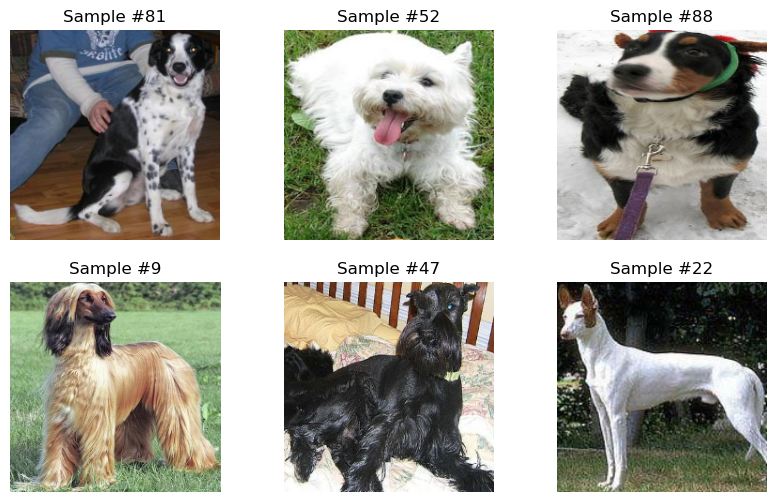

In [11]:
figure, axes = plt.subplots(nrows=2, ncols=3, figsize=(10, 6))
axes = axes.flatten()

for i in range(6):
    rand_i = np.random.randint(0, len(total_dataset))
    sample = total_dataset[rand_i]
    image = sample['image'].permute(1, 2, 0)
    label = sample['label']
    
    mean=torch.tensor([0.485, 0.456, 0.406]) 
    std=torch.tensor([0.229, 0.224, 0.225])
    image.mul_(std)
    image.add_(mean)
    
    axes[i].axis('off')
    #print(image.shape)
    axes[i].imshow(image)
    axes[i].set_title('Sample #{}'.format(label))

# 데이터 적재

In [12]:
batch_size = 24
trainloader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
validloader = DataLoader(valid_set, batch_size=batch_size, shuffle=False)
testloader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

In [13]:
train_iter = iter(trainloader)
batch = next(train_iter)
batch['image'].size(), len(batch['label'])

(torch.Size([24, 3, 224, 224]), 24)

# 모델 생성

In [14]:
import torch.nn as nn # 파이토치에서 제공하는 다양한 계층 (Linear Layer, ....)
import torch.optim as optim # 옵티마이저 (경사하강법...)
import torch.nn.functional as F # 파이토치에서 제공하는 함수(활성화 함수...)

In [15]:
class Inception(nn.Module):
    def __init__(self, in_channels, out1_1, out3_3_r, out3_3, out5_5_r, out5_5, out_pool):
        super().__init__()
        
        self.seq1 = nn.Sequential(
            # 1 * 1 conv
            nn.Conv2d(
                in_channels=in_channels,
                out_channels=out1_1,
                kernel_size=1,
                stride=1,
                padding=0
            ),
            nn.BatchNorm2d(num_features=out1_1)
        )
        
        
        self.seq2 = nn.Sequential(
            # 3 * 3 reduce
            nn.Conv2d(
                in_channels=in_channels,
                out_channels=out3_3_r,
                kernel_size=1,
                stride=1,
                padding=0
            ),

            # 3 * 3 conv
            nn.Conv2d(
                in_channels=out3_3_r,
                out_channels=out3_3,
                kernel_size=3,
                stride=1,
                padding=1
            ),
            nn.BatchNorm2d(num_features=out3_3)
        )
        
        self.seq3 = nn.Sequential(
            # 5 * 5 reduce
            nn.Conv2d(
                in_channels=in_channels,
                out_channels=out5_5_r,
                kernel_size=1,
                stride=1,
                padding=0
            ),

            # 5 * 5 conv
            nn.Conv2d(
                in_channels=out5_5_r,
                out_channels=out5_5,
                kernel_size=5,
                stride=1,
                padding=2
            ),
            nn.BatchNorm2d(num_features=out5_5)
        )
        
        self.seq4 = nn.Sequential(
            # 3 * 3 maxpool
            nn.MaxPool2d(
                kernel_size=3,
                stride=1,
                padding=1
            ),

            # pool proj
            nn.Conv2d(
                in_channels=in_channels,
                out_channels=out_pool,
                kernel_size=1,
                stride=1
            ),
            nn.BatchNorm2d(num_features=out_pool)
        )
    def forward(self, x):
        x1 = self.seq1(x)
        
        x2 = self.seq2(x)
        
        x3 = self.seq3(x)
        
        x4 = self.seq4(x)
        
        
        return torch.cat([x1, x2, x3, x4], dim=1)
        

In [16]:
class GoogLeNet(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=7, stride=2, padding=3),
            nn.BatchNorm2d(num_features=64),
            nn.Dropout2d(p=0.4),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
            
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=1),
            nn.Conv2d(in_channels=64, out_channels=192, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(num_features=192)
            nn.Dropout2d(p=0.4),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        ) # [4, 192, 28, 28]
        
        self.inception_3a = Inception(192, 64, 96, 128, 16, 32, 32)
        self.inception_3b = Inception(256, 128, 128, 192, 32, 96, 64)
        self.max_3 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        
        self.inception_4a = Inception(480, 192,96,208,16,48,64)
        self.inception_4b = Inception(512,160,112,224,24,64,64)
        self.inception_4c = Inception(512,128,128,256,24,64,64)
        self.inception_4d = Inception(512,112,144,288,32,64,64)
        self.inception_4e = Inception(528,256,160,320,32,128,128)
        self.max_4 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        
        self.inception_5a = Inception(832,256,160,320,32,128,128)
        self.inception_5b = Inception(832,384,192,384,48,128,128)
        self.avg = nn.AvgPool2d(kernel_size=7, stride=1)
        self.lin = nn.Linear(in_features=1024, out_features=120)

    
    def forward(self, x):
        x = self.convblock1(x)
        x = self.inception_3a(x)
        x = self.inception_3b(x)
        x = F.dropout2d(x, 0.4)
        x = self.max_3(x)
        
        x = self.inception_4a(x)
        x = self.inception_4b(x)
        x = self.inception_4c(x)
        x = self.inception_4d(x)
        x = self.inception_4e(x)
        x = F.dropout2d(x, 0.4)
        x = self.max_4(x)
        
        x = self.inception_5a(x)
        x = self.inception_5b(x)
        x = F.dropout2d(x, 0.4)
        x = self.avg(x)
        
        x = F.dropout(x, 0.4)
        x = torch.flatten(x, 1)
        x = self.lin(x)
        
        return x

In [17]:
model = GoogLeNet()

In [18]:
model.to(device)

GoogLeNet(
  (convblock1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
    (1): Dropout2d(p=0.4, inplace=False)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
    (4): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): Dropout2d(p=0.4, inplace=False)
    (6): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (inception_3a): Inception(
    (seq1): Sequential(
      (0): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (seq2): Sequential(
      (0): Conv2d(192, 96, kernel_size=(1, 1), stride=(1, 1))
      (1): Conv2d(96, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (seq3): Sequential(


In [19]:
out = model(batch['image'].to(device))
out.shape

torch.Size([24, 120])

In [20]:
learning_rate = 0.0001
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3, verbose=True)

In [21]:
summary(model, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,472
         Dropout2d-2         [-1, 64, 112, 112]               0
         MaxPool2d-3           [-1, 64, 56, 56]               0
            Conv2d-4           [-1, 64, 56, 56]           4,160
            Conv2d-5          [-1, 192, 56, 56]         110,784
         Dropout2d-6          [-1, 192, 56, 56]               0
         MaxPool2d-7          [-1, 192, 28, 28]               0
            Conv2d-8           [-1, 64, 28, 28]          12,352
       BatchNorm2d-9           [-1, 64, 28, 28]             128
           Conv2d-10           [-1, 96, 28, 28]          18,528
           Conv2d-11          [-1, 128, 28, 28]         110,720
      BatchNorm2d-12          [-1, 128, 28, 28]             256
           Conv2d-13           [-1, 16, 28, 28]           3,088
           Conv2d-14           [-1, 32,

# 모델 학습

In [22]:
def validate(model, validloader, loss_fn):
    total = 0   
    correct = 0
    valid_loss = 0
    valid_accuracy = 0

  
    with torch.no_grad():
        for batch in validloader:
            images=batch['image'].to(device)
            labels=batch['label']
            labels = torch.Tensor(labels).to(device)

            logit = model(images) 
            _, preds = torch.max(logit, 1)
            correct += int((preds == labels).sum())
            total += labels.shape[0]

            loss = loss_fn(logit, labels)
            valid_loss += loss.item()

        valid_accuracy = correct / total
  
    return valid_loss, valid_accuracy

In [23]:
writer = SummaryWriter()

In [24]:
def train_loop(model, trainloader, loss_fn, epochs, optimizer):
    steps = 0
    steps_per_epoch = len(trainloader)
    min_loss = np.inf
    max_accuracy = -np.inf
    trigger = 0
    p = 10


    for epoch in range(epochs):
        model.train()
        train_loss = 0

        for batch in trainloader:
            images=batch['image'].to(device)
            labels=batch['label']
            labels = torch.Tensor(labels).to(device)
            
            steps+=1
                      
            predict = model(images)
            loss = loss_fn(predict, labels)

            optimizer.zero_grad()
            loss.backward()

            optimizer.step()

            train_loss += loss.item()

            if (steps % steps_per_epoch) == 0:
                model.eval()
                valid_loss, valid_accuracy = validate(model, validloader, loss_fn)    
                
                print('Epoch : {}/{}.......'.format(epoch+1, epochs),            
                    'Train Loss : {:.3f}'.format(train_loss/len(trainloader)), 
                    'Valid Loss : {:.3f}'.format(valid_loss/len(validloader)), 
                    'Valid Accuracy : {:.3f}'.format(valid_accuracy))

                writer.add_scalar('Train Loss', train_loss/len(trainloader), epoch+1)
                writer.add_scalar('Valid Loss', valid_loss/len(validloader), epoch+1)
                writer.add_scalars('Train Loss and Valid Loss',
                                    {'Train' : train_loss/len(trainloader),
                                    'Valid' : valid_loss/len(validloader)}, epoch+1)
                writer.add_scalar('Valid Accuracy', valid_accuracy, epoch+1)

                if (valid_loss < min_loss) and (valid_accuracy >= max_accuracy):
                    print('save ckpt')
                    min_loss = valid_loss
                    max_accuracy = valid_accuracy

                    best_model = deepcopy(model)
                    torch.save(best_model.state_dict(), 'D:/coding/models/dogs/best_ckpt_google_batch_24_bn.pth')

                
                # --- early stopping --- #
                if valid_loss > min_loss:
                    print('----trigger----', trigger+1)
                    trigger += 1
                    if trigger > p:
                        print('Early Stopping')
                        print('training loop is finished')
                        writer.flush()
                        return 
                else:
                    trigger = 0
                    min_loss = valid_loss
                    
                scheduler.step(valid_loss)
                    
    writer.flush()

In [25]:
epochs = 150
%time train_loop(model, trainloader, loss_fn, epochs, optimizer)
writer.close()

Epoch : 1/150....... Train Loss : 4.722 Valid Loss : 4.518 Valid Accuracy : 0.039
save ckpt
Epoch : 2/150....... Train Loss : 4.465 Valid Loss : 4.383 Valid Accuracy : 0.047
save ckpt
Epoch : 3/150....... Train Loss : 4.343 Valid Loss : 4.238 Valid Accuracy : 0.053
save ckpt
Epoch : 4/150....... Train Loss : 4.251 Valid Loss : 4.196 Valid Accuracy : 0.056
save ckpt
Epoch : 5/150....... Train Loss : 4.173 Valid Loss : 4.073 Valid Accuracy : 0.072
save ckpt
Epoch : 6/150....... Train Loss : 4.103 Valid Loss : 4.161 Valid Accuracy : 0.065
----trigger---- 1
Epoch : 7/150....... Train Loss : 4.029 Valid Loss : 3.970 Valid Accuracy : 0.090
save ckpt
Epoch : 8/150....... Train Loss : 3.942 Valid Loss : 3.844 Valid Accuracy : 0.112
save ckpt
Epoch : 9/150....... Train Loss : 3.865 Valid Loss : 3.770 Valid Accuracy : 0.110
Epoch : 10/150....... Train Loss : 3.779 Valid Loss : 3.742 Valid Accuracy : 0.117
save ckpt
Epoch : 11/150....... Train Loss : 3.705 Valid Loss : 3.633 Valid Accuracy : 0.13

# 모델 예측

In [26]:
test_iter = iter(testloader)
batch = next(test_iter)
images, labels = batch['image'].to(device), batch['label'].to(device)
print(images.size(), labels.size())

rnd_idx = 3
print(images[rnd_idx].shape, labels[rnd_idx])

torch.Size([24, 3, 224, 224]) torch.Size([24])
torch.Size([3, 224, 224]) tensor(3, device='cuda:0')


In [27]:
model.eval()
with torch.no_grad():
    logit = model(images[rnd_idx].unsqueeze(0))
pred = logit.max(dim=1)[1]
print(pred == labels[rnd_idx])

tensor([False], device='cuda:0')


In [28]:
images.shape

torch.Size([24, 3, 224, 224])

pred: tensor([6], device='cuda:0') labels: tensor(3, device='cuda:0')
torch.Size([224, 224, 3])


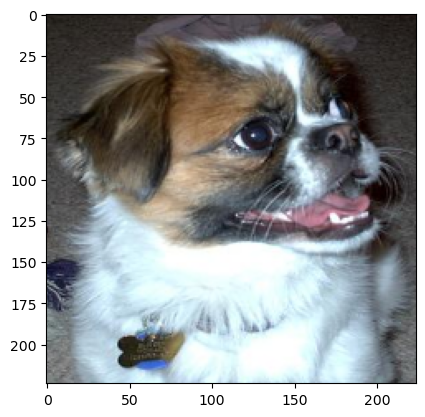

In [29]:
print("pred:", pred, "labels:", labels[rnd_idx])

images = images[rnd_idx].permute(1, 2, 0).cpu()
mean=torch.tensor([0.485, 0.456, 0.406]) 
std=torch.tensor([0.229, 0.224, 0.225])
images.mul_(std)
images.add_(mean)
print(images.shape)
plt.imshow(images)

In [30]:
def evaluation(model, testloader, loss_fn):
    total = 0   
    correct = 0
    test_loss = 0
    test_accuracy = 0

    with torch.no_grad():
        for batch in testloader:
            images, labels = batch['image'].to(device), batch['label'].to(device)

            logit = model(images)
            _, preds = torch.max(logit, 1)

            correct += int((preds == labels).sum())
            total += labels.shape[0]

            loss = loss_fn(logit, labels)
            test_loss += loss.item()
            
        test_accuracy = correct / total
   
        print('Test Loss : {:.3f}'.format(test_loss/len(testloader)), 
            'Test Accuracy : {:.3f}'.format(test_accuracy))

model.eval()
evaluation(model, testloader, loss_fn)  

Test Loss : 2.570 Test Accuracy : 0.352


# 모델 저장 및 불러오기

In [31]:
torch.save(model.state_dict(), 'D:/coding/models/dogs/last_ckpt_google_batch_24_bn.pth')

In [32]:
last_state_dict = torch.load('D:/coding/models/dogs/last_ckpt_google_batch_24_bn.pth')

In [33]:
last_model = GoogLeNet()
last_model.to(device)
last_model.load_state_dict(last_state_dict)

<All keys matched successfully>

In [34]:
last_model.eval()
evaluation(last_model, testloader, loss_fn)  

Test Loss : 2.588 Test Accuracy : 0.342


In [35]:
best_state_dict = torch.load('D:/coding/models/dogs/best_ckpt_google_batch_24_bn.pth')
best_model = GoogLeNet()
best_model.to(device)
best_model.load_state_dict(best_state_dict)

<All keys matched successfully>

In [36]:
best_model.eval()
evaluation(best_model, testloader, loss_fn)

Test Loss : 2.538 Test Accuracy : 0.348
